<a href="https://www.kaggle.com/rsizem2/tps-09-21-simple-xgboost-model?scriptVersionId=84703099" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Simple XGBoost Models

In this notebook we get a baseline for the GPU-enabled XGBoost model. We mostly use default settings except for the following:

* We set a higher value for `n_estimators`, a lower value for `learning_rate` and enable `early_stopping_rounds` to avoid overfitting on each fold

We use [this dataset](https://www.kaggle.com/rsizem2/tps0921foldsfeather), which is equivalent to the original data except we have a predefined cross-validation scheme and each feature has been downcast to it's lowest possible subtype.

In [1]:
# Global variables for testing changes to this notebook quickly
NUM_FOLDS = 8  
RANDOM_SEED = 0
NUM_TREES = 2000
EARLY_STOP = 50
SUBMIT = True

In [2]:
# Essentials
import numpy as np
import pandas as pd
import scipy.stats as stats
import pyarrow
import pickle
import time
import matplotlib
from matplotlib import pyplot as plt

# Models and Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier, plot_importance

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [3]:
%%time
# Load data
train = pd.read_csv('../input/tabular-playground-series-sep-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-sep-2021/test.csv')
submission = pd.read_csv('../input/tabular-playground-series-sep-2021/sample_solution.csv')

# Drop ID
train.drop('id', axis = 'columns', inplace = True)
test.drop('id', axis = 'columns', inplace = True)

# Downcast training data
for col, dtype in train.dtypes.iteritems():
    if dtype.name.startswith('int'):
        train[col] = pd.to_numeric(train[col], downcast ='integer')
    elif dtype.name.startswith('float'):
        train[col] = pd.to_numeric(train[col], downcast ='float')

# Downcast test data
for col, dtype in test.dtypes.iteritems():
    if dtype.name.startswith('int'):
        test[col] = pd.to_numeric(test[col], downcast ='integer')
    elif dtype.name.startswith('float'):
        test[col] = pd.to_numeric(test[col], downcast ='float')

# Feature columns
features = [x for x in train.columns if x not in ['id','claim']]

CPU times: user 40.1 s, sys: 14.6 s, total: 54.8 s
Wall time: 1min 4s


## Helper Functions

### 1. Scoring Function

In [4]:
def score_xgboost():

    # Vectors to store predictions/scores
    test_preds, oof_preds = np.zeros((test.shape[0],)), np.zeros((train.shape[0],))
    fi_scores, scores = np.zeros(len(features)), np.zeros(NUM_FOLDS)

    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train["claim"])):
       
        # Training and Validation Sets
        X_train, X_valid = train[features].iloc[train_idx], train[features].iloc[valid_idx]
        y_train, y_valid = train["claim"].iloc[train_idx], train["claim"].iloc[valid_idx]

        start = time.time()

        # Define model
        model = XGBClassifier(
            random_state = RANDOM_SEED,
            n_estimators = NUM_TREES,
            tree_method='gpu_hist',
            gpu_id=0,
            predictor="gpu_predictor",
        )

        # Train model
        model.fit(
                X_train, y_train,
                verbose = False,
                eval_set = [(X_train, y_train), (X_valid, y_valid)],
                eval_metric = ["auc","logloss"],
                early_stopping_rounds = EARLY_STOP
        )

        # Get predictions
        valid_preds = model.predict_proba(X_valid)[:,1]
        test_preds += model.predict_proba(test[features])[:, 1] / NUM_FOLDS
        fi_scores += model.feature_importances_ / NUM_FOLDS
        oof_preds[valid_idx] = valid_preds
        scores[fold] = roc_auc_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} (AUC): {round(scores[fold], 6)} in {round(end-start, 3)}s')

    print("\nAverage AUC:", round(scores.mean(), 6))
    print("Worst AUC:", round(scores.min(), 6))
    return model, scores.mean(), oof_preds, test_preds, fi_scores

### 2. Training Plot

In [5]:
def training_plot(xgb_model):
    # Get model evaluation results
    results = xgb_model.evals_result()
    num_iter = len(results['validation_0']['auc'])
    x_axis = range(0, num_iter)

    # Plot training curve
    fig, ax = plt.subplots(figsize = (9,6))
    ax.plot(x_axis, results['validation_0']['auc'], label='Train')
    ax.plot(x_axis, results['validation_1']['auc'], label='Valid')
    plt.axvline(x=xgb_model.best_iteration, color='k', linestyle='--')
    ax.legend()
    plt.ylabel('AUC')
    plt.xlabel('Iterations')
    plt.title('XGBoost AUC')
    plt.grid(True)
    plt.show()

# XGBoost Baseline

In [6]:
model, score, oof_preds, test_preds, fi_scores = score_xgboost()

submission['claim'] = test_preds
submission.to_csv('baseline_submission.csv', index=False)

Fold 0 (AUC): 0.797528 in 15.336s
Fold 1 (AUC): 0.798549 in 10.299s
Fold 2 (AUC): 0.801243 in 10.617s
Fold 3 (AUC): 0.800219 in 10.467s
Fold 4 (AUC): 0.798626 in 11.303s
Fold 5 (AUC): 0.80114 in 10.735s
Fold 6 (AUC): 0.797047 in 10.277s
Fold 7 (AUC): 0.797199 in 10.253s

Average AUC: 0.798944
Worst AUC: 0.797047


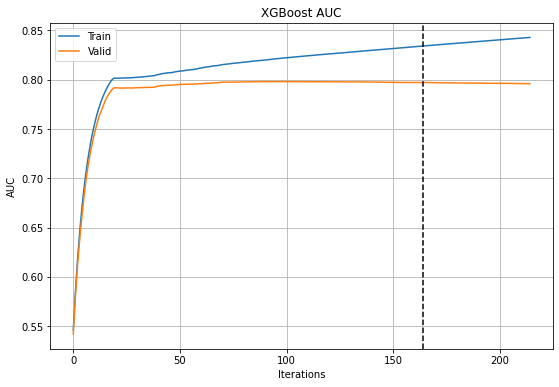

In [7]:
training_plot(model)

# Feature Engineering

In [8]:
def create_row_stats(data):
    data['nan_count'] = data[features].isnull().sum(axis=1)
    data['nan_std'] = data[features].isnull().std(axis=1)
    data['min'] = data[features].min(axis=1)
    data['std'] = data[features].std(axis=1)
    data['max'] = data[features].max(axis=1)
    data['median'] = data[features].median(axis=1)
    data['mean'] = data[features].mean(axis=1)
    data['var'] = data[features].var(axis=1)
    data['sum'] = data[features].sum(axis=1)
    data['sem'] = data[features].sem(axis=1)
    data['skew'] = data[features].skew(axis=1)
    data['median_abs_dev'] = stats.median_abs_deviation(data[features], axis=1)
    data['zscore'] = (np.abs(stats.zscore(data[features]))).sum(axis=1)
    return data

## Train Model

In [9]:
# Create new features
train = create_row_stats(train)
test = create_row_stats(test)
features = [x for x in train.columns if x not in ['id','claim']]

model, score, oof_preds, test_preds, fi_scores = score_xgboost()

fi_scores = pd.Series(
    data = fi_scores, 
    index = features
).sort_values(ascending = False)

Fold 0 (AUC): 0.809346 in 8.773s
Fold 1 (AUC): 0.811055 in 9.372s
Fold 2 (AUC): 0.812221 in 8.961s
Fold 3 (AUC): 0.810373 in 8.137s
Fold 4 (AUC): 0.810025 in 8.667s
Fold 5 (AUC): 0.811578 in 8.312s
Fold 6 (AUC): 0.809167 in 8.391s
Fold 7 (AUC): 0.808225 in 9.133s

Average AUC: 0.810249
Worst AUC: 0.808225


## Feature Importances

We look at the most important and least important features as determined by XGBoost

In [10]:
# Most important features
fi_scores.head(5)

nan_count    0.869648
f40          0.001890
f70          0.001691
median       0.001431
f47          0.001410
dtype: float64

In [11]:
# Least important features
fi_scores.tail(5)

f85        0.000874
std        0.000859
var        0.000000
nan_std    0.000000
zscore     0.000000
dtype: float64

# Final Submission

We use only the features which XGBoost found more important than any of the original features.

## Remove Low Importance Features

In [12]:
# Remove low importance features
train.drop(['nan_std','var','zscore','std'], axis = 'columns', inplace = True)
test.drop(['nan_std','var','zscore','std'], axis = 'columns', inplace = True)
features = [x for x in test.columns]

model, score, oof_preds, test_preds, fi_scores = score_xgboost()

submission['claim'] = test_preds
submission.to_csv('best_features_submission.csv', index=False)

Fold 0 (AUC): 0.809816 in 8.284s
Fold 1 (AUC): 0.811067 in 8.758s
Fold 2 (AUC): 0.812179 in 8.408s
Fold 3 (AUC): 0.810373 in 8.192s
Fold 4 (AUC): 0.810319 in 8.348s
Fold 5 (AUC): 0.811647 in 8.046s
Fold 6 (AUC): 0.808165 in 7.559s
Fold 7 (AUC): 0.808232 in 9.447s

Average AUC: 0.810225
Worst AUC: 0.808165
